In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installments + functions developed

In [ ]:
!pip install kaggle
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np

#Visual
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot') # Set the style to 'ggplot' instead of 'default'

#Modeling
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator #to resize the image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Gradcam functions

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image

def get_img_array(img_path, size):
    img = keras_image.load_img(img_path, target_size=size)
    array = keras_image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
         last_conv_layer_output, preds = grad_model(img_array)
         if pred_index is None:
            pred_index = tf.argmax(preds[0])
         class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.7):
      # Load the original image
      img = keras_image.load_img(img_path)
      img = keras_image.img_to_array(img)

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras_image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras_image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on the original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras_image.array_to_img(superimposed_img)

      # Display Grad CAM
      plt.imshow(superimposed_img)
      plt.axis('off')
      plt.show()

def save_and_display_gradcam_grid(img_path, heatmap, alpha=0.7):
      # Load the original image
      img = keras_image.load_img(img_path)
      img = keras_image.img_to_array(img)

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras_image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras_image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on the original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras_image.array_to_img(superimposed_img)

      superimposed_img = keras.utils.array_to_img(superimposed_img)

      return superimposed_img

# Assuming similar_image_paths is a list of file paths for the top 5 similar images
img_size = (299, 299)  # Size for InceptionV3
last_conv_layer_name = 'mixed10'  # Last conv layer in InceptionV3

# Importing the data

Loading the data from Kaggle

-API token for Kaggle, needed

In [ ]:
import os
import zipfile
from google.colab import files

# Path to the Kaggle directory and JSON file
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

# Check if the kaggle.json file exists
if not os.path.exists(kaggle_json_path):
  print("Upload your kaggle.json file.")
  files.upload()

  # Create Kaggle directory if it doesn't exist
  os.makedirs(kaggle_dir, exist_ok=True)
  os.system('cp kaggle.json ~/.kaggle/')
  os.system('chmod 600 ~/.kaggle/kaggle.json')

# Path to the ZIP file
zip_file_path = '100-bird-species.zip'

# Check if the ZIP file already exists
if not os.path.exists(zip_file_path):
  # Download the dataset
  os.system('kaggle datasets download -d gpiosenka/100-bird-species')

  # Extract the dataset
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
else:
  print("ZIP file already exists.")

# Path to the expected birds.csv file within the dataset
birds_csv_path = 'birds.csv'

# Check if the dataset needs to be downloaded and extracted
if not os.path.exists(zip_file_path) or not os.path.exists(birds_csv_path):
  # Download the dataset if the ZIP file is not present
  if not os.path.exists(zip_file_path):
    os.system('kaggle datasets download -d gpiosenka/100-bird-species')
    # Extract the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall()
else:
  print("Dataset already extracted.")

Upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset already extracted.


In [ ]:
#For delving into the paths
from pathlib import Path

In [ ]:
######################### TRAIN #########################
train_path = '/content/train'

train_dir = Path(train_path)

filepaths = list(train_dir.glob(r'**/*.JPG')) + list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.png')) + list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

train_df = pd.concat([filepaths, labels], axis=1)


In [ ]:
######################### TEST #########################
test_path = '/content/test'

test_dir = Path(test_path)

filepaths = list(test_dir.glob(r'**/*.JPG')) + list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.png')) + list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

test_df = pd.concat([filepaths, labels], axis=1)

The dataset handcrafted

The images were taken from the following website: https://avibase.bsc-eoc.org/search.jsp

In [ ]:
######################### BIRDS_TEST #########################

base_path = 'path...'

birds_test_path= base_path + "/Birds_signals_submission/crafted_data/birds_test"

birds_test_dir=Path(birds_test_path)

filepaths = list(birds_test_dir.glob(r'**/*.JPG')) + list(birds_test_dir.glob(r'**/*.jpg')) + list(birds_test_dir.glob(r'**/*.png')) + list(birds_test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

birds_test_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
birds_test_df.head()

,filepaths,labels
0,/content/drive/MyDrive/Progetti_uni/Progetto D...,PEACOCK
1,/content/drive/MyDrive/Progetti_uni/Progetto D...,PEACOCK
2,/content/drive/MyDrive/Progetti_uni/Progetto D...,PEACOCK
3,/content/drive/MyDrive/Progetti_uni/Progetto D...,MERLIN
4,/content/drive/MyDrive/Progetti_uni/Progetto D...,MERLIN


In [ ]:
birds_test_df.shape

(50, 2)

Image data generator

- Is applied the preprocessing: `inception_v3.preprocess_input`

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(test_df
                                                  ,x_col='filepaths'
                                                  ,y_col='labels'
                                                  ,target_size = (150, 150)
                                                  ,batch_size = 20
                                                  ,shuffle = False
                                                       )

Found 2625 validated image filenames belonging to 525 classes.


In [ ]:
birds_test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

birds_test_generator = birds_test_datagen.flow_from_dataframe(birds_test_df
                                                  ,x_col='filepaths'
                                                  ,y_col='labels'
                                                  ,target_size = (150, 150)
                                                  ,batch_size = 20
                                                  ,shuffle = False
                                                       )

Found 50 validated image filenames belonging to 17 classes.


# IV3TF inference + evaluation

# Loading the model:

In [ ]:
base_path = 'path...'

modelpath = base_path + '/Birds_signals_submission/models_used/image_classification/IV3TRF.keras'

model = keras.models.load_model(modelpath)

# Performing inference on the **test set**

Use the model to perform inference:

In [ ]:
# use the model to predict all test images
pred = model.predict(test_generator)
pred = np.argmax(pred, axis = 1)

# Map the label
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

#save the ground truth
y_test = list(test_df.labels)

132/132 [==============================] - 7s 40ms/step


# Evaluation on the **test set**

The test set was evaluated based on the following metrics:

- accuracy

- precision / recall

- f1Score

Checking the accuracy of the model:

In [ ]:
acc = accuracy_score(y_test, pred)
print(f"Accuracy score: {np.round(acc, 3)}")

Accuracy score: 0.855


Overall performances

In [ ]:
#Compute the classification report
report = classification_report(y_test, pred, output_dict=True, zero_division=0)

#save it on a data frame
report_df = pd.DataFrame(report).transpose()[:525]

keys = list(report["weighted avg"].keys())[:-1]
for elem in keys:
    print(f"{elem}: {round(report['weighted avg'][elem], 3)}")

precision: 0.88
recall: 0.855
f1-score: 0.852


- Overall the accuarcy on the test set is 85.5%

- The precision and the recall have almost similar results above the 80%, which makes the f1score equal to 85.2%

### Are there any bird species that are not accurately predicted by the CNN?


- Checking the F1, precision and recall scores distribution between the 525 classes, to assess which bird species our model was unable to predict accurately.

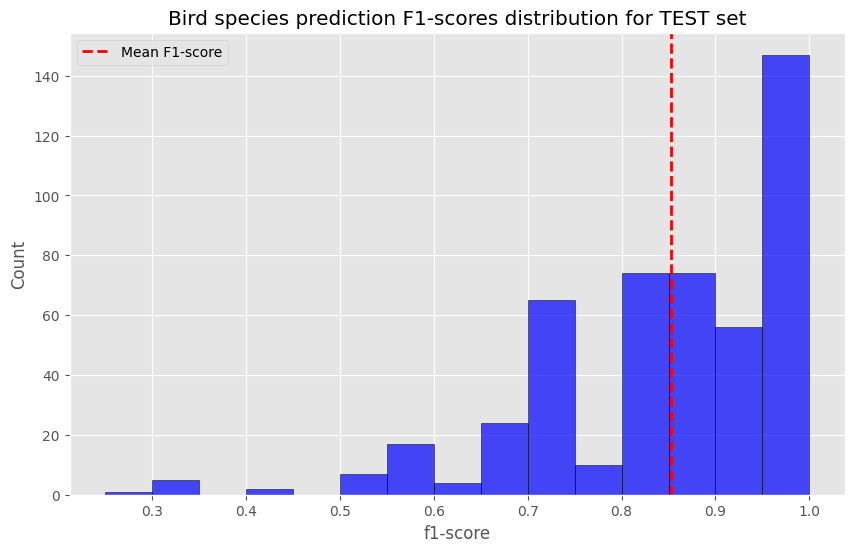

In [ ]:
# Extract the F1-score column (assuming the column name is 'f1-score')
f1_scores = report_df['f1-score']

# Plot the histogram
plt.figure(figsize=(10,6))
plt.hist(f1_scores, bins=15, color='blue', edgecolor='black', alpha=0.7)
plt.title('Bird species prediction F1-scores distribution for TEST set')
plt.xlabel('f1-score')
plt.ylabel('Count')
# Plot the mean line
mean_line = plt.axvline(f1_scores.mean(), color='red', linestyle='dashed', linewidth=2)
# Add a legend
plt.legend([mean_line], ['Mean F1-score'])
plt.show()

By plotting each bird species’ F1-Score on a distribution plot, we can see that there are 165 (30.4% of total) bird species with F1-Scores lesser than 0.8.

Same check for precision and recall:


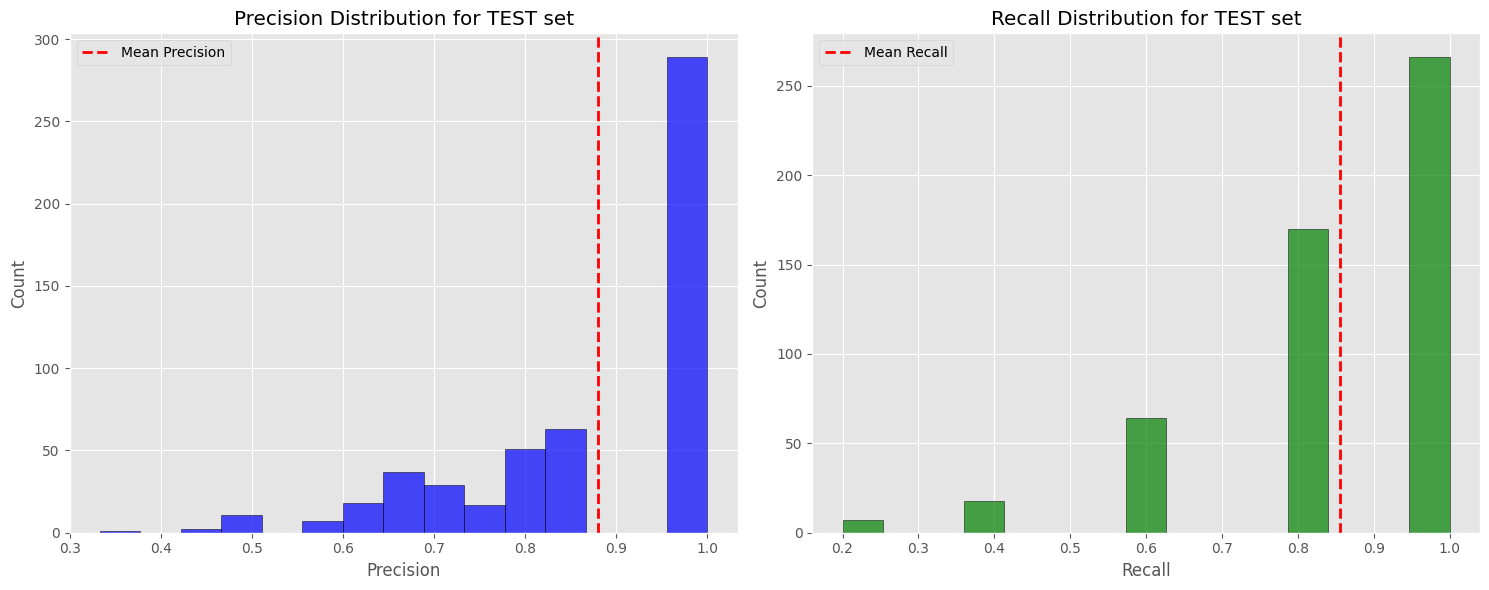

In [ ]:
# Plotting Precision and Recall histograms side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot Precision Histogram
axes[0].hist(report_df['precision'], bins=15, color='blue', edgecolor='black', alpha=0.7)
axes[0].axvline(report_df['precision'].mean(), color='red', linestyle='dashed', linewidth=2)
axes[0].set_title('Precision Distribution for TEST set')
axes[0].set_xlabel('Precision')
axes[0].set_ylabel('Count')
axes[0].legend(['Mean Precision'])

# Plot Recall Histogram
axes[1].hist(report_df['recall'], bins=15, color='green', edgecolor='black', alpha=0.7)
axes[1].axvline(report_df['recall'].mean(), color='red', linestyle='dashed', linewidth=2)
axes[1].set_title('Recall Distribution for TEST set')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Count')
axes[1].legend(['Mean Recall'])

# Show the plot
plt.tight_layout()
plt.show()

To better assess which species are mostly wrongly classified, there will be visualized the bottom 12 species in terms of f1score

In [ ]:

# Get the bottom 12 bird species with the lowest F1 scores
report_df = report_df.iloc[:-3].copy()
f1_score = np.round(report_df.sort_values('f1-score')[:12]["f1-score"],3)
bottom12_birds_array = report_df.sort_values('f1-score')[:12].index

# Prepare the training data for visualization
dedup_train_df = train_df.drop_duplicates('labels')
dedup_train_df = dedup_train_df[dedup_train_df['labels'].isin(bottom12_birds_array)]

# Organize the training data for consistent display
dedup_train_df['labels'] = pd.Categorical(dedup_train_df['labels'], categories=bottom12_birds_array)
dedup_train_df.sort_values('labels', inplace=True)
dedup_train_df.reset_index(drop=True, inplace=True)

# Set up a matplotlib figure to display the images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
# Populate each subplot with an image and its title
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dedup_train_df.filepaths[i]))
    tit = f"{dedup_train_df.labels[i]} (F1: {f1_score[i]})"
    ax.set_title(tit, color='black')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Overall the worst predicted species by the model is the **Austral Canestero** with 0.25 F1score

# Picking 12 random birds from the test set, and check the predictions + Grad-CAM visualization

In [ ]:
# Display 12 random pictures from the dataset with their labels

#set the seed
np.random.seed(88)

#random extraction
random_index = np.random.randint(0, len(test_df) - 1, 24)

#setup the grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

#save the path of the mistakes
path_mistakes = []

#print the 12 random birds from the test set
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepaths.iloc[random_index[i]]))
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
        path_mistakes.append(test_df.filepaths.iloc[random_index[i]])  #save the mistaken paths
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Grad-CAM visualization
Grad-CAM, which stands for Gradient-weighted Class Activation Mapping, is a technique used in the field of computer vision, particularly in the interpretation of deep learning models. It helps in understanding which parts of a given image led a Convolutional Neural Network (CNN) to its final decision in classification tasks.

- Deep dive on visualizing the patterns learnt by the CNN layers

- Then a focus will be on the three birds missclassified

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # load the image
    img_path = test_df.filepaths.iloc[random_index[i]]

    # prepare the image_array
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # prepare the heatmap array
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed_img = save_and_display_gradcam_grid(img_path, heatmap)

    # Display the superimposed image on the subplot
    ax.imshow(superimposed_img)
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
        path_mistakes.append(test_df.filepaths.iloc[random_index[i]])  #save the mistaken paths
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In every bird image, we find the areas of the image that are important for the CNN to make its class predictions.

For the IWI species (first row, forth column) as we can see the CNN has made the correct prediction because of its red neck. This is also true for the CRIMSON SUNBIRD (forth row, first column).

To this section will follow a deep dive on the three bird species missclassified

- BAY-BREASTED WARBLER

- NORTHERN BEARDLESS TYRANNULET

- WHITE EARED HUMMINGBIRD

### BAY-BREASTED WARBLER

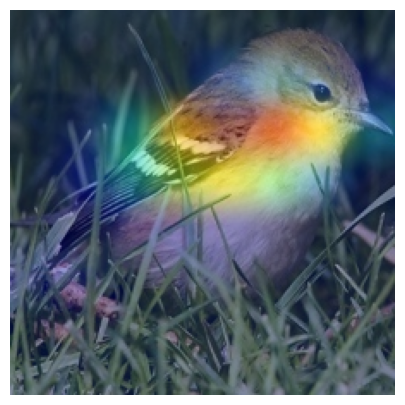

In [ ]:
path= path_mistakes[0]

# Generate and display Grad-CAM heatmap
img_array = preprocess_input(get_img_array(path, size=img_size))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(path, heatmap)

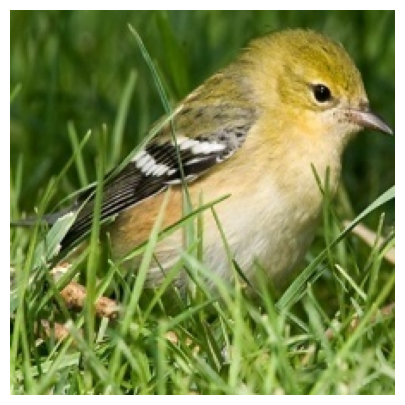

In [ ]:
img = keras_image.load_img(path)
plt.imshow(img)
plt.axis('off')
plt.show()

The uncorrectly classified species:

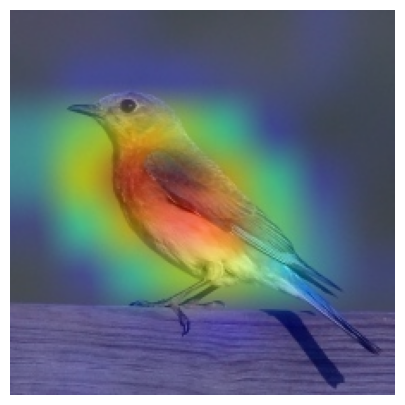

In [ ]:
path1 = '/content/train/EASTERN BLUEBIRD/010.jpg'
# Generate and display Grad-CAM heatmap
img_array = preprocess_input(get_img_array(path1, size=img_size))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(path1, heatmap)

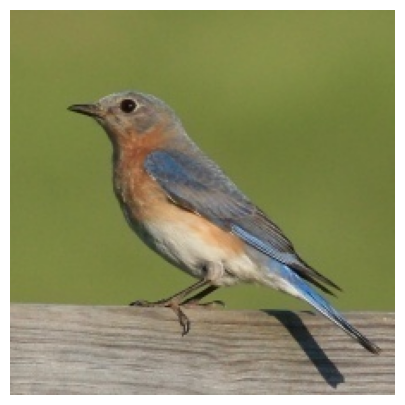

In [ ]:
img = keras_image.load_img(path1)
plt.imshow(img)
plt.axis('off')
plt.show()

For the BAY-BREASTED WARBLER species, the CNN focuses on the wing. This might be the cause of confusion with the EASTERN BLUEBIRD

### NORTHERN BEARDLESS TYRANNULET

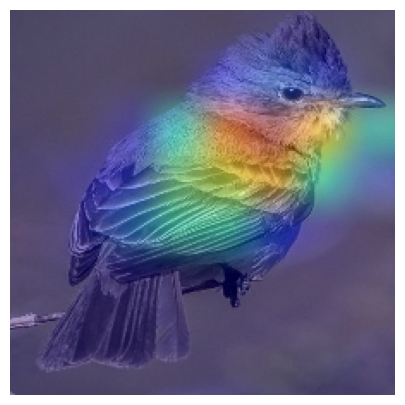

In [ ]:
path= path_mistakes[1]

# Generate and display Grad-CAM heatmap
img_array = preprocess_input(get_img_array(path, size=img_size))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(path, heatmap)

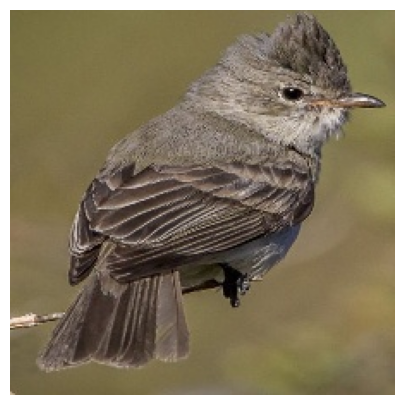

In [ ]:
img = keras_image.load_img(path)
plt.imshow(img)
plt.axis('off')
plt.show()

The uncorrectly classified species:

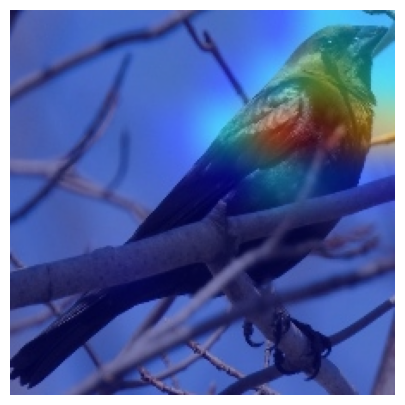

In [ ]:
path1 = '/content/train/BROWN HEADED COWBIRD/010.jpg'
# Generate and display Grad-CAM heatmap
img_array = preprocess_input(get_img_array(path1, size=img_size))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(path1, heatmap)

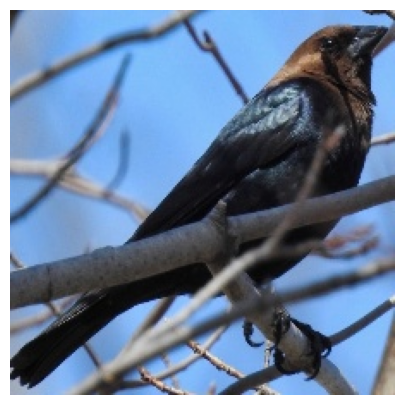

In [ ]:
img = keras_image.load_img(path1)
plt.imshow(img)
plt.axis('off')
plt.show()

For the NORTHERN BEARDLESS TYRANNULET species, the CNN focuses on the spout. This might be the reason of confusion with the BROWN HEADED COWBIRD species

### WHITE EARED HUMMINGBIRD

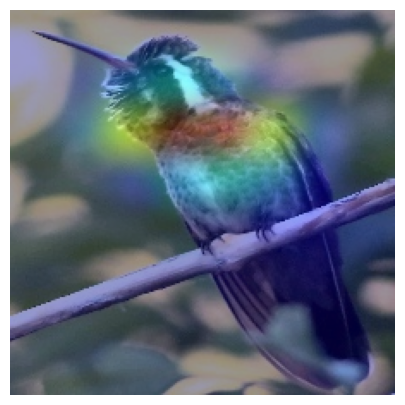

In [ ]:
path= path_mistakes[2]

# Generate and display Grad-CAM heatmap
img_array = preprocess_input(get_img_array(path, size=img_size))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(path, heatmap)

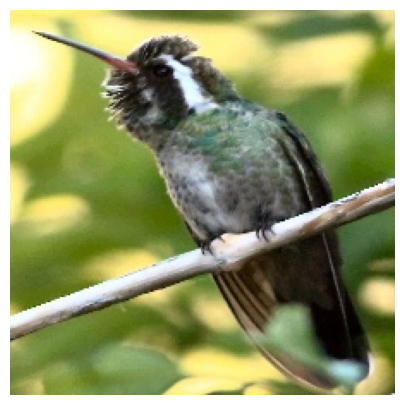

In [ ]:
img = keras_image.load_img(path)
plt.imshow(img)
plt.axis('off')
plt.show()

The uncorrectly classified species:

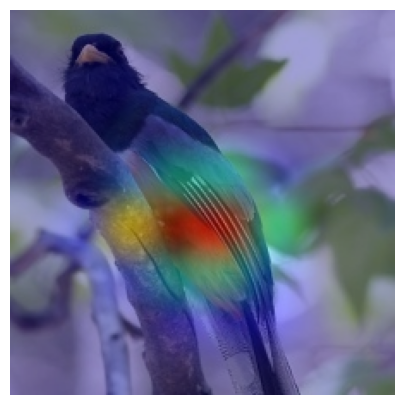

In [ ]:
path1 = '/content/train/ELEGANT TROGON/010.jpg'
# Generate and display Grad-CAM heatmap
img_array = preprocess_input(get_img_array(path1, size=img_size))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(path1, heatmap)

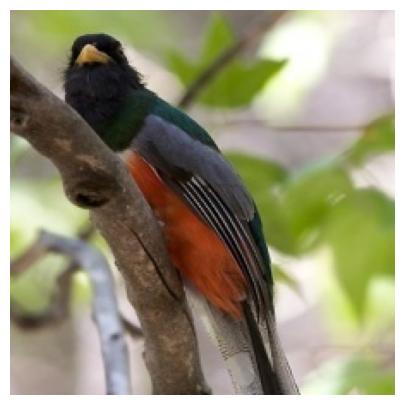

In [ ]:
img = keras_image.load_img(path1)
plt.imshow(img)
plt.axis('off')
plt.show()

# Evaluation of the **handcrafted dataset**

Perform the inference on the handcrafted dataset of 50 images `birds_test`

In [ ]:
# use the model to predict all test images
pred = model.predict(birds_test_generator)
pred = np.argmax(pred, axis = 1)

# Map the label
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

#retrieve the ground truth species labels
y_test = list(birds_test_df.labels)

3/3 [==============================] - 18s 7s/step


## Metrics for evaluation

In [ ]:
accuracy_score(y_test, pred)

0.34

In [ ]:
#Compute the classification report
report = classification_report(y_test, pred, output_dict=True, zero_division=0)

#save it on a data frame
report_df = pd.DataFrame(report).transpose()[:525]

keys = list(report["weighted avg"].keys())[:-1]
for elem in keys:
    print(f"{elem}: {round(report['weighted avg'][elem], 3)}")

precision: 0.58
recall: 0.34
f1-score: 0.405


The accuracy on the handcrafted test set is 34%, while the F1score is 40.5%

- The results are not so good compared to the test set, however the following considerations can be done, for better contenstualizing the result:

  1. From the 525 species the handcrafted test set contains only 17 species, randomly selected.

  2. The images from the kaggle dataset are perfectly centered and the bird takes most of the image space. This wasn't done with the e handcrafted test set to better evaluate the model with imperfect images and also to better evaluate how the data augmentation improved the predictions.

  

## Display 12 random pictures from the dataset with their labels


In [ ]:
#set the seed
np.random.seed(123)

#random extraction
random_index = np.random.randint(0, len(birds_test_df) - 1, 24)

#setup the grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

#save the path of the mistakes
path_mistakes = []

#print the 12 random birds from the test set
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(birds_test_df.filepaths.iloc[random_index[i]]))
    if birds_test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
        path_mistakes.append(birds_test_df.filepaths.iloc[random_index[i]])  #save the mistaken paths
    ax.set_title(f"True: {birds_test_df.labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.